In [13]:
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END

# 1. Inicializamos el modelo apuntando a tu Docker local
model = ChatOllama(
    model="qwen3:1.7b",      # El nombre exacto que pusiste en tu Dockerfile/Compose
    temperature=0,           # Temperatura 0 es ideal para uso de herramientas (más preciso)
    base_url="http://localhost:11434" # La dirección de tu contenedor
)

In [14]:
class GraphState(dict):
    email_content: str      # El correo de entrada
    intent: str             # La clasificación (BUG, DOCS, OTHER)
    context_data: str       # Datos recuperados (de búsqueda o bug tracker)
    draft_reply: str        # El borrador de respuesta generado
    confidence_score: float # Para decidir si pasa a revisión humana final

In [15]:
import random

# --- NODO: READ EMAIL ---
def read_email(state: GraphState):
    print("📧 [Node] Read Email")
    
    # Ejemplos de correos de cada tipo
    email_examples = {
        "BUG": [
            "Hola, encontré un error crítico al hacer login en la app. Sale error 500.",
            "La aplicación se bloquea cuando intento subir archivos mayores a 10MB.",
            "El botón de guardar no funciona en la sección de configuración.",
        ],
        "DOCS": [
            "¿Cómo puedo integrar tu API con mi aplicación de Node.js?",
            "¿Dónde está la documentación sobre autenticación OAuth?",
            "Necesito saber cuál es el límite de requests por minuto.",
        ],
        "OTHER": [
            "Hola, solo quería felicitar al equipo por el buen trabajo.",
            "¿Tienen planes de expansión a Latinoamérica?",
            "Interesado en ofertas de empleo para el equipo.",
        ]
    }
    
    # Seleccionamos un tipo aleatorio
    random_type = random.choice(list(email_examples.keys()))
    random_email = random.choice(email_examples[random_type])
    
    print(f"   ---> Tipo aleatorio seleccionado: {random_type}")
    return {"email_content": random_email}

# --- NODO: CLASSIFY INTENT ---
def classify_intent(state: GraphState):
    print("🧠 [Node] Classify Intent")
    email = state["email_content"]
    
    # Prompt mejorado para mayor precisión
    prompt = f"""Clasifica este correo en UNA de estas categorías:
Email: "{email}"

Responde SOLO con UNA palabra:
- BUG (reportan un error o problema técnico)
- DOCS (piden ayuda o información sobre cómo usar algo)
- OTHER (cualquier otra cosa)

Tu respuesta debe ser SOLO: BUG, DOCS, u OTHER"""
    
    response = model.invoke(prompt).content.strip().upper()
    
    # Limpieza más robusta
    intent = "OTHER"
    if "BUG" in response:
        intent = "BUG"
    elif "DOCS" in response:
        intent = "DOCS"
    
    print(f"   ---> Intención detectada: {intent}")
    return {"intent": intent}

# --- RAMA A: DOC SEARCH ---
def doc_search(state: GraphState):
    print("🔍 [Node] Doc Search")
    return {"context_data": "Documentación encontrada: El login requiere autenticación de dos factores."}

# --- RAMA B: BUG TRACK ---
def bug_track(state: GraphState):
    print("🪲 [Node] Bug Track")
    return {"context_data": "Ticket creado en Jira: ID-404. Estado: Investigando."}

# --- RAMA C: HUMAN REVIEW (Inicial) ---
def human_review_logic(state: GraphState):
    print("👤 [Node] Human Review (Classification)")
    return {"context_data": "Nota del agente humano: Tratar con delicadeza, cliente VIP."}

# --- NODO: DRAFT REPLY ---
def draft_reply(state: GraphState):
    print("✍️ [Node] Draft Reply")
    email = state["email_content"]
    context = state.get("context_data", "")
    
    prompt = f"""Eres un asistente de soporte.
Correo del usuario: {email}
Información de contexto: {context}

Escribe una respuesta breve y amable."""
    
    draft = model.invoke(prompt).content
    
    # Simulamos un puntaje de confianza
    # Si el email tiene contexto de Jira (bug), confianza alta
    fake_confidence = 0.9 if "Ticket" in context or "ID-" in context else 0.4
    
    return {"draft_reply": draft, "confidence_score": fake_confidence}

# --- NODO: FINAL HUMAN REVIEW ---
def final_human_review(state: GraphState):
    print("👀 [Node] Final Human Review")
    # Aquí un humano editaría el draft
    return {"draft_reply": state["draft_reply"] + " (Aprobado por Humano)"}

# --- NODO: SEND REPLY ---
def send_reply(state: GraphState):
    print("🚀 [Node] Send Reply")
    print(f"   >>> ENVIANDO: {state['draft_reply']}")
    return {}


In [16]:
# Decisión 1: Después de clasificar
def route_intent(state: GraphState):
    intent = state["intent"]
    if intent == "DOCS":
        return "doc_search"
    elif intent == "BUG":
        return "bug_track"
    else:
        return "human_review_logic"

# Decisión 2: Después de redactar (¿Está bien o necesita revisión?)
def route_approval(state: GraphState):
    score = state["confidence_score"]
    # Si la confianza es baja (< 0.5), mandamos a revisión
    if score < 0.5:
        print("   ---> Confianza baja. Requiere revisión humana.")
        return "final_human_review"
    else:
        print("   ---> Confianza alta. Enviando directo.")
        return "send_reply"

In [17]:
workflow = StateGraph(GraphState)

# 1. AÑADIR TODOS LOS NODOS
workflow.add_node("read_email", read_email)
workflow.add_node("classify_intent", classify_intent)
workflow.add_node("doc_search", doc_search)
workflow.add_node("bug_track", bug_track)
workflow.add_node("human_review_logic", human_review_logic)
workflow.add_node("draft_reply", draft_reply)
workflow.add_node("final_human_review", final_human_review)
workflow.add_node("send_reply", send_reply)

# 2. FLUJO PRINCIPAL (Inicio)
workflow.add_edge(START, "read_email")
workflow.add_edge("read_email", "classify_intent")

# 3. DECISIÓN CONDICIONAL: clasificar y elegir rama
workflow.add_conditional_edges(
    "classify_intent",
    route_intent,
    {
        "doc_search": "doc_search",
        "bug_track": "bug_track",
        "human_review_logic": "human_review_logic",
    }
)

# 4. CONVERGENCIA: todas las ramas van a draft_reply
workflow.add_edge("doc_search", "draft_reply")
workflow.add_edge("bug_track", "draft_reply")
workflow.add_edge("human_review_logic", "draft_reply")

# 5. SEGUNDA DECISIÓN: después de redactar, revisar o enviar
workflow.add_conditional_edges(
    "draft_reply",
    route_approval,
    {
        "final_human_review": "final_human_review",
        "send_reply": "send_reply",
    }
)

# 6. FINALIZACIÓN
workflow.add_edge("final_human_review", "send_reply")
workflow.add_edge("send_reply", END)

# Compilar
app = workflow.compile()


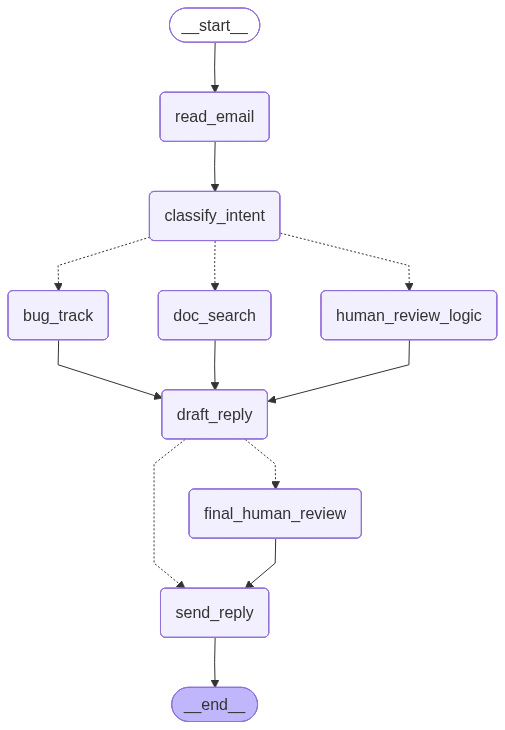


--- EJECUTANDO FLUJO ---

📧 [Node] Read Email
   ---> Tipo aleatorio seleccionado: OTHER
🧠 [Node] Classify Intent
   ---> Intención detectada: OTHER
👤 [Node] Human Review (Classification)
✍️ [Node] Draft Reply
   ---> Intención detectada: OTHER
👤 [Node] Human Review (Classification)
✍️ [Node] Draft Reply
   ---> Confianza baja. Requiere revisión humana.
👀 [Node] Final Human Review
🚀 [Node] Send Reply
   >>> ENVIANDO: ¡Hola! Estoy encantado de oír que estás interesado en las oportunidades de empleo del equipo. ¡Es un honor poder ayudarte! Me encantaría asesorarte sobre cómo obtener más información o cómo podemos coordinar una conversación más detallada. ¿En qué te puedo ayudar hoy? 🌟 (Aprobado por Humano)
   ---> Confianza baja. Requiere revisión humana.
👀 [Node] Final Human Review
🚀 [Node] Send Reply
   >>> ENVIANDO: ¡Hola! Estoy encantado de oír que estás interesado en las oportunidades de empleo del equipo. ¡Es un honor poder ayudarte! Me encantaría asesorarte sobre cómo obtener más

In [18]:
# Generar el diagrama en el notebook (opcional, requiere graphviz)
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    print("No se pudo dibujar el gráfico (quizás falta instalar dependencies de visualización), pero el código funcionará igual.")

print("\n--- EJECUTANDO FLUJO ---\n")

# Ejecutamos el flujo
# Nota: No pasamos input inicial porque el nodo 'read_email' simula la entrada.
output = app.invoke({})